In [77]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy.spatial.distance import cdist
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
from scipy.fftpack import dct
import torch.nn.functional as F
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Preprocessing Step
Computes features useful to a decision tree such as chunk by chunk similarity metrics, averages, and maximums, as well as neighbor similarities
Does this for all authentic and forged train data, and makes into one dataframe

In [2]:
def load_images_as_tensor(folder_path, img_size=None):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    tensors = []

    for fname in tqdm(image_files):
        path = os.path.join(folder_path, fname)
        try:
            
            img = Image.open(path).convert("RGB")
            img_np = np.array(img, dtype=np.float32) / 255.0
            img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
            tensors.append(img_tensor)
            
        except Exception as e:
            print(f"Warning: could not read {path}: {e}")

    if len(tensors) == 0:
        raise ValueError("No valid images found in folder.")
        
    return tensors

In [3]:
folder = "data/train_images/authentic"

dataset_auth = load_images_as_tensor(folder, img_size=(128, 128))

100%|██████████| 2377/2377 [01:34<00:00, 25.06it/s]


[tensor([[[0.5059, 0.4039, 0.3020,  ..., 0.2392, 0.2353, 0.2235],
         [0.3804, 0.3294, 0.2784,  ..., 0.2392, 0.2353, 0.2431],
         [0.3529, 0.3137, 0.2627,  ..., 0.2353, 0.2353, 0.2314],
         ...,
         [0.2824, 0.2549, 0.2431,  ..., 0.9922, 0.9961, 0.9882],
         [0.2784, 0.2627, 0.2471,  ..., 1.0000, 0.9882, 0.9922],
         [0.2745, 0.2667, 0.2471,  ..., 1.0000, 0.9961, 0.9961]],

        [[0.5059, 0.4039, 0.3020,  ..., 0.2392, 0.2353, 0.2235],
         [0.3804, 0.3294, 0.2784,  ..., 0.2392, 0.2353, 0.2431],
         [0.3529, 0.3137, 0.2627,  ..., 0.2353, 0.2353, 0.2314],
         ...,
         [0.2824, 0.2549, 0.2431,  ..., 0.9922, 0.9961, 0.9882],
         [0.2784, 0.2627, 0.2471,  ..., 1.0000, 0.9882, 0.9922],
         [0.2745, 0.2667, 0.2471,  ..., 1.0000, 0.9961, 0.9961]],

        [[0.5059, 0.4039, 0.3020,  ..., 0.2392, 0.2353, 0.2235],
         [0.3804, 0.3294, 0.2784,  ..., 0.2392, 0.2353, 0.2431],
         [0.3529, 0.3137, 0.2627,  ..., 0.2353, 0.2353, 0

In [4]:
folder = "data/train_images/forged"

dataset_forge = load_images_as_tensor(folder, img_size=(128, 128))

100%|██████████| 2751/2751 [02:25<00:00, 18.97it/s]


AttributeError: 'list' object has no attribute 'size'

In [5]:
def block_features(img, grid_size=20):
    C, H, W = img.shape

    # 1. Convert to grayscale
    if C == 3:
        gray = 0.2989 * img[0] + 0.5870 * img[1] + 0.1140 * img[2]
    else:
        gray = img.squeeze(0)
    
    grid_size = 20
    # Compute boundaries
    h_edges = torch.linspace(0, H, grid_size + 1, dtype=torch.int32)
    w_edges = torch.linspace(0, W, grid_size + 1, dtype=torch.int32)
    
    patches = []
    for i in range(grid_size):
        for j in range(grid_size):
            h_start, h_end = h_edges[i].item(), h_edges[i+1].item()
            w_start, w_end = w_edges[j].item(), w_edges[j+1].item()
            patch = gray[h_start:h_end, w_start:w_end]
            patches.append(patch.flatten())
    
    # 3. Pad patches to the same length
    max_len = max(p.size(0) for p in patches)
    padded_patches = torch.stack([F.pad(p, (0, max_len - p.size(0))) for p in patches])
    
    # 4. Normalize for cosine similarity
    normalized = F.normalize(padded_patches, dim=1)
    S = normalized @ normalized.T
    
    mean_sim = (S.sum() - S.trace()) / (S.numel() - S.shape[0])
    
    off_diag = S[~torch.eye(S.shape[0], dtype=bool)]
    std_sim = off_diag.std()
    
    max_sim = off_diag.max()
    
    min_sim = off_diag.min()
    
    high_sim_frac = (off_diag > 0.8).float().mean()
    
    low_sim_frac = (off_diag < 0.2).float().mean()
    
    adj_S = S.reshape(20, 20, 20, 20)
    adj_sum = 0
    count = 0
    for i in range(20):
        for j in range(20):
            neighbors = []
            if i < 19: neighbors.append(adj_S[i,j,i+1,j])
            if j < 19: neighbors.append(adj_S[i,j,i,j+1])
            if i > 0: neighbors.append(adj_S[i,j,i-1,j])
            if j > 0: neighbors.append(adj_S[i,j,i,j-1])
            if neighbors:
                adj_sum += torch.stack(neighbors).mean()
                count += 1
    adjacent_mean_sim = adj_sum / count
    
    # 8. Variance of similarities across the grid (flattened)
    grid_var = S.var()
    
    # 9. Entropy-like measure of similarity distribution
    hist = torch.histc(off_diag, bins=10, min=0, max=1)
    hist_prob = hist / hist.sum()
    entropy_sim = -(hist_prob * torch.log(hist_prob + 1e-8)).sum()
    
    # 10. Skewness of similarity distribution
    mean_off = off_diag.mean()
    std_off = off_diag.std()
    skew_sim = ((off_diag - mean_off)**3).mean() / (std_off**3 + 1e-8)
    
    # Combine into feature vector
    features = {
        "mean_sim": mean_sim.item(),
        "std_sim": std_sim.item(),
        "max_sim": max_sim.item(),
        "min_sim": min_sim.item(),
        "high_sim_frac": high_sim_frac.item(),
        "low_sim_frac": low_sim_frac.item(),
        "adjacent_mean_sim": adjacent_mean_sim.item(),
        "grid_var": grid_var.item(),
        "entropy_sim": entropy_sim.item(),
        "skew_sim": skew_sim.item()
    }
    
    return features

In [6]:
rows = []
for tensor in tqdm(dataset_auth):
    rows.append(block_features(tensor))
df_auth = pd.DataFrame(rows)
df_auth['classification'] = 1

100%|██████████| 2377/2377 [02:00<00:00, 19.78it/s]


In [15]:
rows = []
for tensor in tqdm(dataset_forge):
    rows.append(block_features(tensor))
df_forge = pd.DataFrame(rows)
df_forge['classification'] = 0

100%|██████████| 2751/2751 [02:14<00:00, 20.48it/s]


In [18]:
df_tree = pd.concat([df_auth, df_forge])
df_tree.to_csv("data/df_tree_train.csv")
df_tree

,mean_sim,std_sim,max_sim,min_sim,high_sim_frac,low_sim_frac,adjacent_mean_sim,grid_var,entropy_sim,skew_sim,classification
0,0.921493,0.056668,0.999954,0.488890,0.961479,0.000000,0.925350,0.003219,0.733626,-1.265295,1
1,0.951605,0.061775,0.988348,0.268696,0.964925,0.000000,0.951605,0.003812,0.307552,-4.471314,1
2,0.982264,0.020130,0.999972,0.865705,1.000000,0.000000,0.987269,0.000405,0.005888,-0.937347,1
3,0.931239,0.064555,0.996874,0.421043,0.960363,0.000000,0.937188,0.004169,0.703486,-1.230815,1
4,0.912516,0.048319,0.999999,0.445156,0.972444,0.000000,0.914567,0.002348,0.736521,-1.218582,1
...,...,...,...,...,...,...,...,...,...,...,...
2746,0.910416,0.080300,1.000000,0.461941,0.927130,0.000000,0.925276,0.006452,0.929258,-1.509520,0
2747,0.883039,0.143319,0.984822,0.000000,0.853421,0.014737,0.890083,0.020533,1.096869,-3.608394,0
2748,0.923954,0.062453,0.999996,0.502833,0.956416,0.000000,0.928750,0.003905,0.747359,-1.217876,0
2749,0.968913,0.023065,0.999998,0.795592,0.999975,0.000000,0.974223,0.000533,0.057326,-1.159452,0


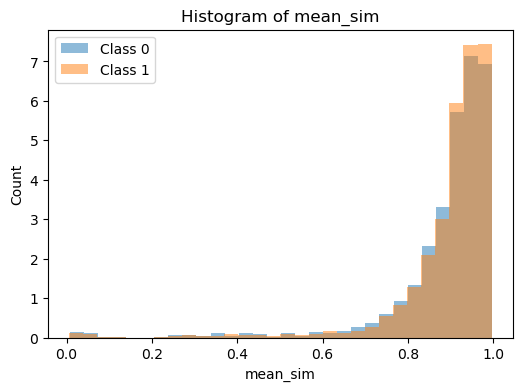

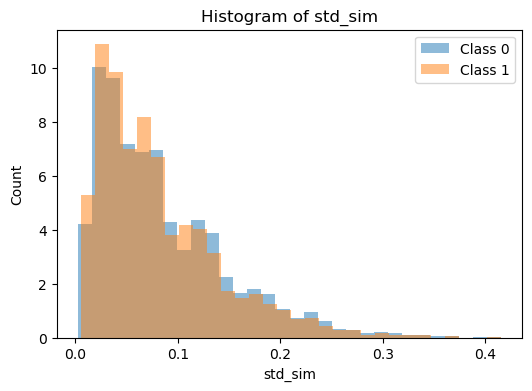

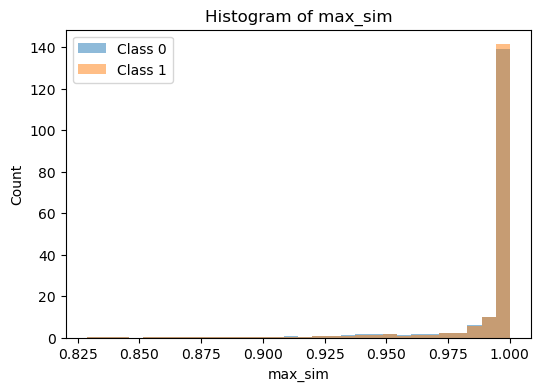

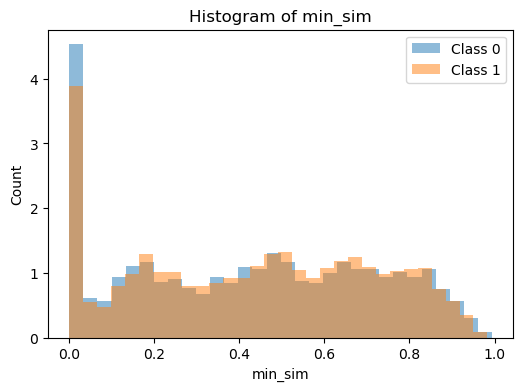

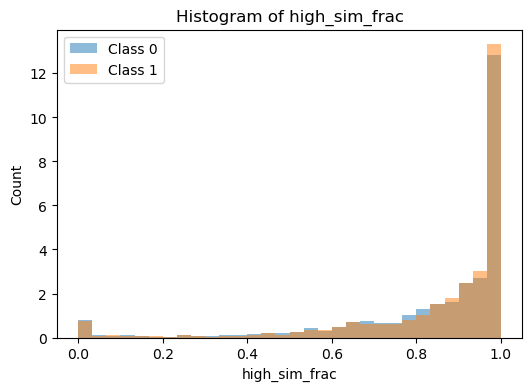

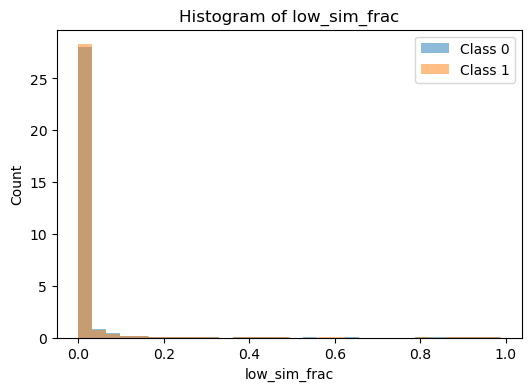

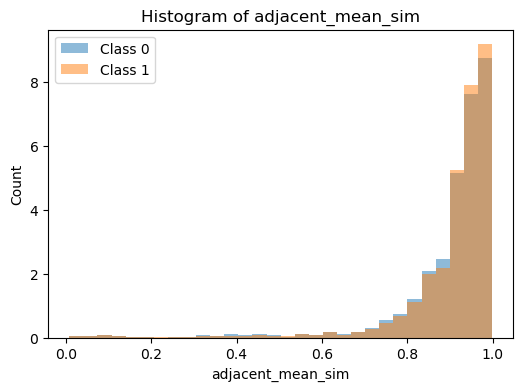

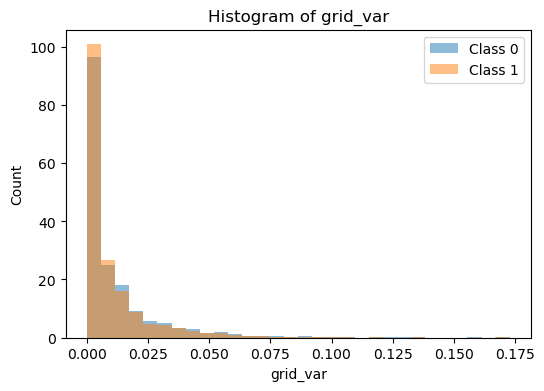

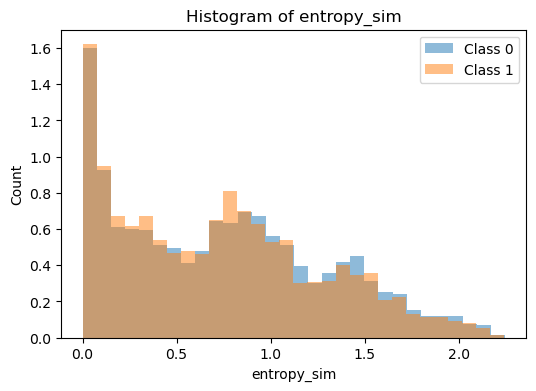

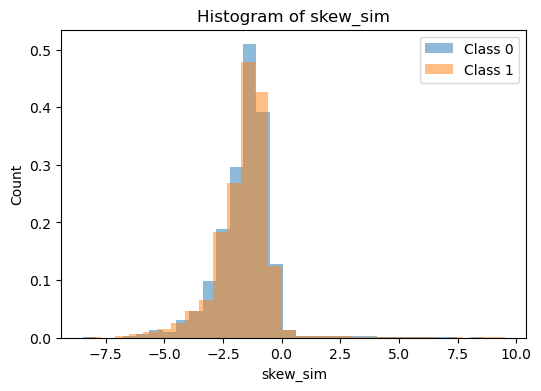

In [28]:
feature_columns = [col for col in df_tree.columns if col != 'classification']

for feature in feature_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(df_tree[df_tree['classification'] == 0][feature], bins=30, alpha=0.5, label='Class 0', density=True)
    plt.hist(df_tree[df_tree['classification'] == 1][feature], bins=30, alpha=0.5, label='Class 1', density=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [91]:
# Convert DataFrame to numpy arrays
X = df_tree.drop(columns=['classification']).values
y = df_tree['classification'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.3363


In [93]:
for i in range(1, 50, 4):
    clf = DecisionTreeClassifier(random_state=42, max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {i}: {acc:.4f}")

Accuracy for 1: 0.5361
Accuracy for 5: 0.5331
Accuracy for 9: 0.5205
Accuracy for 13: 0.4932
Accuracy for 17: 0.4620
Accuracy for 21: 0.4191
Accuracy for 25: 0.4113
Accuracy for 29: 0.4025
Accuracy for 33: 0.4123
Accuracy for 37: 0.4006
Accuracy for 41: 0.3928
Accuracy for 45: 0.3713
Accuracy for 49: 0.3791


In [94]:
for i in range(50, 0, -4):
    clf = DecisionTreeClassifier(random_state=42, min_samples_split=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {i}: {acc:.4f}")

Accuracy for 50: 0.4103
Accuracy for 46: 0.4055
Accuracy for 42: 0.4142
Accuracy for 38: 0.3967
Accuracy for 34: 0.4025
Accuracy for 30: 0.3860
Accuracy for 26: 0.3830
Accuracy for 22: 0.3889
Accuracy for 18: 0.3606
Accuracy for 14: 0.3694
Accuracy for 10: 0.3489
Accuracy for 6: 0.3528
Accuracy for 2: 0.3363


In [95]:
for i in range(50, 0, -4):
    clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {i}: {acc:.4f}")

Accuracy for 50: 0.4678
Accuracy for 46: 0.4659
Accuracy for 42: 0.4532
Accuracy for 38: 0.4483
Accuracy for 34: 0.4415
Accuracy for 30: 0.4366
Accuracy for 26: 0.4347
Accuracy for 22: 0.4474
Accuracy for 18: 0.4396
Accuracy for 14: 0.4464
Accuracy for 10: 0.4172
Accuracy for 6: 0.3869
Accuracy for 2: 0.3558


In [97]:
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional extra metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = rf.feature_importances_
for name, importance in zip(df_tree.drop(columns=['classification']).columns, importances):
    print(f"{name}: {importance:.4f}")

Accuracy: 0.3908

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       550
           1       0.26      0.16      0.20       476

    accuracy                           0.39      1026
   macro avg       0.35      0.38      0.35      1026
weighted avg       0.36      0.39      0.37      1026


Confusion Matrix:
[[323 227]
 [398  78]]
mean_sim: 0.1205
std_sim: 0.1070
max_sim: 0.0863
min_sim: 0.0869
high_sim_frac: 0.0955
low_sim_frac: 0.0277
adjacent_mean_sim: 0.1235
grid_var: 0.1092
entropy_sim: 0.1171
skew_sim: 0.1263


In [98]:
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional extra metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = rf.feature_importances_
for name, importance in zip(df_tree.drop(columns=['classification']).columns, importances):
    print(f"{name}: {importance:.4f}")

Accuracy: 0.4181

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       550
           1       0.22      0.10      0.14       476

    accuracy                           0.42      1026
   macro avg       0.35      0.40      0.35      1026
weighted avg       0.36      0.42      0.37      1026


Confusion Matrix:
[[380 170]
 [427  49]]
mean_sim: 0.1177
std_sim: 0.1147
max_sim: 0.0878
min_sim: 0.0802
high_sim_frac: 0.0865
low_sim_frac: 0.0452
adjacent_mean_sim: 0.1212
grid_var: 0.1125
entropy_sim: 0.1088
skew_sim: 0.1254
